In [1]:
import pykite as pk
from utils import dql, dql_eval, plot_trajectory
from learning.deep.models import NN, NN5
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
n_attack=pk.coefficients.shape[0]
n_bank=pk.bank_angles.shape[0]
n_beta=pk.n_beta
gamma=1
eps0=0.01
eta0=0.01
episode_duration=300
learning_step=0.2
horizon=int(episode_duration/learning_step)
integration_step=0.001
integration_steps_per_learning_step=int(learning_step/integration_step)

In [3]:
torch.manual_seed(0)
np.random.seed(0)
net=NN()

durations, rewards,_,_,_=dql(net, 'sgd', 1000, horizon, learning_step, integration_step, integration_steps_per_learning_step, pk.vect(np.pi/6, 0, 50), pk.vect(0, 0, 0), 10, lr_decay_start=100000, eps_decay_start=200000, eps=eps0, lr=eta0)


0
epsilon  0.01  eta 0.01 Simulation failed at learning step:  166  reward  -2.523517746266716
1
epsilon  0.05  eta 0.01 Simulation failed at learning step:  736  reward  2.8721422536146664
2
epsilon  0.01  eta 0.01 Simulation failed at learning step:  138  reward  -2.453094661831668
3
epsilon  0.05  eta 0.01 Simulation failed at learning step:  373  reward  -1.197657729212177
4
epsilon  0.05  eta 0.01 Simulation failed at learning step:  532  reward  1.9446624917461175
5
epsilon  0.01  eta 0.01 Simulation failed at learning step:  87  reward  -2.6868785662019055
6
epsilon  0.01  eta 0.01 Simulation failed at learning step:  162  reward  -2.488763343682125
7
epsilon  0.05  eta 0.01 Simulation failed at learning step:  468  reward  1.6338385025571285
8
epsilon  0.01  eta 0.01 Simulation failed at learning step:  129  reward  -2.5257508277752994
9
epsilon  0.05  eta 0.01 Simulation failed at learning step:  439  reward  1.6549716987444512
10
epsilon  0.01  eta 0.01 Simulation failed at l

KeyboardInterrupt: 

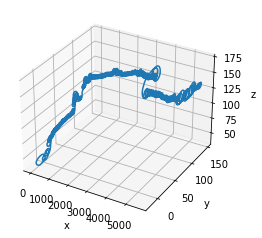

In [8]:
theta=np.array(theta)
phi=np.array(phi)
r=np.array(r)
plot_trajectory(theta[::1], phi[::1], r[::1])

In [4]:
for i, param in enumerate(net.parameters()):
        print(param)

Parameter containing:
tensor([[-0.0006,  0.2210, -0.3360, -0.3004, -0.1573,  0.1233],
        [-0.0078,  0.3212, -0.0362,  0.1076, -0.1235, -0.0195],
        [-0.3906, -0.2713, -0.1683,  0.0151,  0.1616,  0.2339],
        [-0.2776, -0.1792,  0.1483,  0.3388, -0.0841,  0.2880],
        [-0.0655,  0.0440,  0.3697, -0.3789, -0.2567, -0.1446],
        [-0.1462,  0.3574, -0.2646, -0.1884, -0.2842, -0.2692],
        [-0.2388,  0.3480,  0.1822,  0.1984,  0.0226, -0.1923],
        [ 0.0636, -0.3820, -0.2950, -0.2106,  0.2577,  0.2318],
        [-0.1811, -0.0138,  0.2611,  0.4057,  0.1621,  0.0695],
        [ 0.2698, -0.2331,  0.0761, -0.3155, -0.2835, -0.2733],
        [ 0.1833,  0.1649, -0.2418,  0.1236,  0.2241, -0.0864],
        [ 0.0156,  0.0952,  0.2533,  0.3915, -0.3142, -0.1659],
        [ 0.1659,  0.3389,  0.3553,  0.3599,  0.0817, -0.2410],
        [ 0.0241, -0.2627, -0.3805,  0.3619,  0.3108, -0.4042],
        [ 0.0784, -0.0683, -0.0672, -0.1866,  0.1568, -0.2724],
        [ 0.1488, 

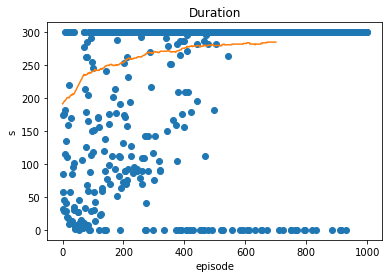

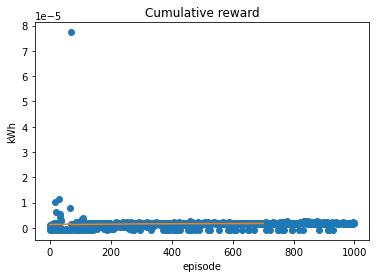

In [4]:
plt.figure()
plt.title("Duration")
s_durations=np.array(durations)*0.2
plt.plot(s_durations, 'o')
plt.plot(np.convolve(s_durations, np.ones(300), 'valid') / 300)
plt.xlabel("episode")
plt.ylabel("s")
plt.show()
plt.figure()
kwh_rewards=np.array(rewards)/3.6e6
plt.title("Cumulative reward")
plt.plot(kwh_rewards, 'o')
plt.plot(np.convolve(kwh_rewards, np.ones(300), 'valid') / 300)
plt.xlabel("episode")
plt.ylabel("kWh")
plt.show()

In [5]:
from utils import apply_action

def dql_eval(net, horizon, integration_step, integration_steps_per_learning_step, initial_position, initial_velocity, wind):
    theta=[]
    phi=[]
    r=[]
    net.eval()
    k=pk.kite(initial_position, initial_velocity, wind)
    initial_beta=k.beta()
    S_t=(14,3,initial_beta)
    acc=k.accelerations()
    S_t+=acc
    for i in range(horizon):
        tensor_state=torch.tensor(S_t).float()
        tensor_state[0]/=n_attack
        tensor_state[1]/=n_bank
        tensor_state[2]/=n_beta
        q=net(tensor_state).reshape(3,3)
        print(torch.max(q))
        print(S_t)
        theta.append(k.position.theta)
        phi.append(k.position.phi)
        r.append(k.position.r)
        A_t=(q==torch.max(q)).nonzero().reshape(-1)
        A_t=A_t[0],A_t[1]
        #print(A_t)
        new_attack_angle, new_bank_angle=apply_action(S_t, A_t)
        status=k.evolve_system(new_attack_angle, new_bank_angle, integration_steps_per_learning_step, integration_step)
        if not status==0:
            print("Simulation failed at learning step: ", i)
            break
        S_t = (new_attack_angle, new_bank_angle, k.beta())
        acc=k.accelerations()
        S_t+=acc
        #visits[S_t]+=1
        if i==int(horizon)-1:
            print( "Simulation ended at learning step: ", i)
    return theta, phi, r

tensor(-0.0809, grad_fn=<MaxBackward1>)
tensor(-0.1044, grad_fn=<MaxBackward1>)
tensor(-0.0941, grad_fn=<MaxBackward1>)
tensor(-0.0917, grad_fn=<MaxBackward1>)
tensor(-0.0955, grad_fn=<MaxBackward1>)
tensor(-0.0918, grad_fn=<MaxBackward1>)
tensor(-0.0890, grad_fn=<MaxBackward1>)
tensor(-0.0872, grad_fn=<MaxBackward1>)
tensor(-0.0820, grad_fn=<MaxBackward1>)
tensor(-0.0862, grad_fn=<MaxBackward1>)
tensor(-0.0895, grad_fn=<MaxBackward1>)
tensor(-0.0843, grad_fn=<MaxBackward1>)
tensor(-0.0856, grad_fn=<MaxBackward1>)
tensor(-0.0839, grad_fn=<MaxBackward1>)
tensor(-0.0863, grad_fn=<MaxBackward1>)
tensor(-0.0842, grad_fn=<MaxBackward1>)
tensor(-0.0880, grad_fn=<MaxBackward1>)
tensor(-0.0916, grad_fn=<MaxBackward1>)
tensor(-0.0912, grad_fn=<MaxBackward1>)
tensor(-0.0927, grad_fn=<MaxBackward1>)
tensor(-0.0951, grad_fn=<MaxBackward1>)
tensor(-0.0963, grad_fn=<MaxBackward1>)
tensor(-0.0956, grad_fn=<MaxBackward1>)
tensor(-0.0976, grad_fn=<MaxBackward1>)
tensor(-0.0973, grad_fn=<MaxBackward1>)


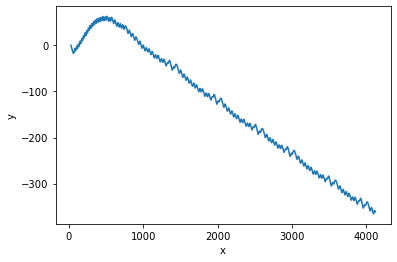

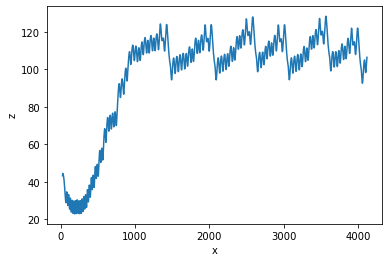

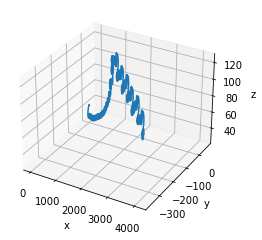

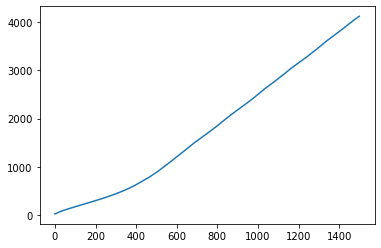

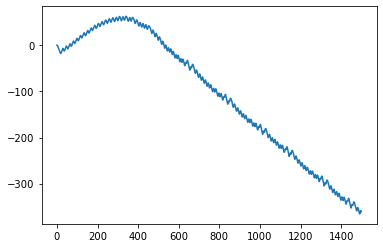

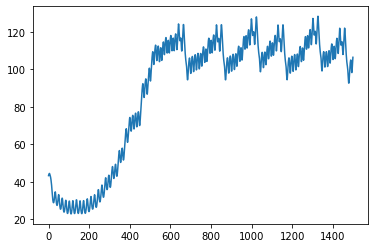

In [4]:
theta, phi, r=dql_eval(net, horizon, integration_step, integration_steps_per_learning_step, pk.vect(np.pi/6, 0, 50), pk.vect(0, 0, 0), 10)

theta=np.array(theta)
phi=np.array(phi)
r=np.array(r)
x=np.multiply(r, np.multiply(np.sin(theta), np.cos(phi)))
y=np.multiply(r, np.multiply(np.sin(theta), np.sin(phi)))
z=np.multiply(r, np.cos(theta))
plt.xlabel("x")
plt.ylabel("y")
plt.plot(x,y)
plt.figure()
plt.xlabel("x")
plt.ylabel("z")
plt.plot(x,z)
plot_trajectory(theta[::1], phi[::1], r[::1])
plt.figure()
plt.plot(x)
plt.figure()
plt.plot(y)
plt.figure()
plt.plot(z)

1   [42, 44, 43, 57, 57, 43, 42, 44, 40, 40]
1   [1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499]
1   [1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499]
1   [32, 36, 38, 42, 26, 39, 44, 38, 30, 27]
1   [212, 156, 185, 1499, 1, 1499, 1499, 1499, 1308, 2]
1   [13, 9, 7, 6, 4, 4, 9, 1, 1, 20]
1   [1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499]


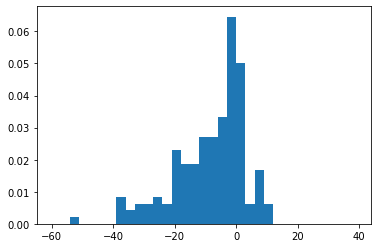

(160,)
2   [1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499]
2   [87, 92, 138, 85, 140, 156, 81, 139, 180, 119]
2   [1499, 1155, 607, 1499, 443, 850, 1181, 567, 83, 1499]
2   [55, 50, 110, 121, 67, 213, 237, 256, 386, 252]
2   [1499, 1499, 1499, 1499, 1499, 1499, 4, 1499, 1499, 1499]
2   [1499, 1499, 1499, 444, 1499, 1499, 42, 1499, 1499, 1499]


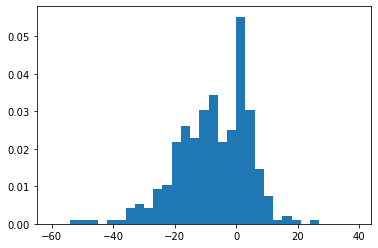

(320,)
4   [1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499]
4   [15, 15, 15, 30, 1, 37, 22, 10, 4, 8]
4   [533, 737, 891, 527, 867, 504, 1127, 484, 658, 1175]
4   [23, 356, 1353, 9, 25, 4, 1, 18, 23, 4]
4   [163, 144, 169, 183, 164, 160, 165, 167, 168, 189]
4   [1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499]
4   [100, 104, 433, 81, 99, 100, 249, 98, 247, 193]
4   [1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499]


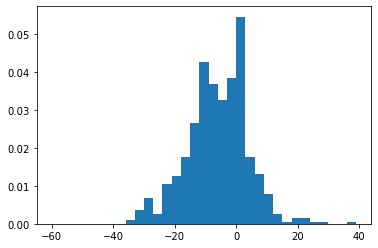

(640,)
8   [1499, 1499, 1499, 1, 3, 43, 27, 1499, 1499, 37]
8   [547, 1421, 654, 421, 671, 483, 380, 459, 465, 601]
8   [1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499]
8   [10, 2, 1, 27, 42, 1499, 1499, 1499, 1499, 1499]
8   [461, 18, 15, 4, 11, 22, 11, 11, 7, 23]
8   [1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499]
8   [889, 811, 787, 836, 804, 820, 1019, 795, 761, 867]
8   [1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499]


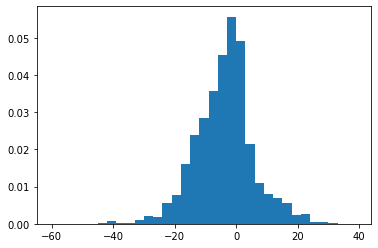

(1280,)


In [3]:
#import sys
factors=[1,2,4,8]
runs=3
episodes=1000
gamma=1
eps0=0.01
eta0=0.1
episode_duration=300
learning_step=0.2
horizon=int(episode_duration/learning_step)
integration_step=0.001
integration_steps_per_learning_step=int(learning_step/integration_step)

for f in factors:
    run_params=[]
    count=0
    while True:
        #print("p")
        net=NN5(f)
        #save_stdout = sys.stdout
        #sys.stdout = open('trash', 'w')
        durations, rewards=dql5(net, episodes, horizon, learning_step, integration_step, integration_steps_per_learning_step, pk.vect(np.pi/6, 0, 50), pk.vect(0, 0, 0), pk.vect(10, 0, 0), lr_decay_start=150000, eps_decay_start=200000, verbose=False)
        #sys.stdout = save_stdout
        print(f," ", durations[-10:])
        if np.mean(np.array(durations[-10:]))>1200:
            count+=1
            for i, param in enumerate(net.parameters()):
                if i==0:
                    param_list=torch.flatten(param).detach().numpy()
            run_params.append(param_list)
            if count==3:
                torch.save(net.state_dict(), 'model%d.pt'%f)
                break
    run_params=np.array(run_params)
    run_params=np.mean(run_params, axis=0)
    plt.figure()
    plt.hist(run_params, bins=np.arange(-20,14)*3, density=True)
    plt.show()
    print(run_params.shape)